In [2]:
# mnist with pytorch
# https://nextjournal.com/gkoehler/pytorch-mnist

# install pytorch https://pytorch.org/
# conda install pytorch torchvision cpuonly -c pytorch
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100.1%

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw


113.5%

Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw


100.4%

Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw


180.4%

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw
Processing...
Done!


In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

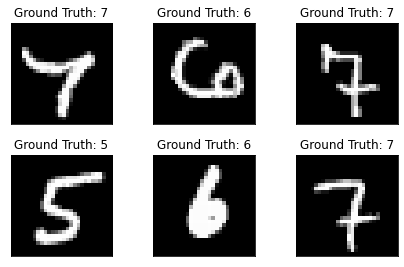

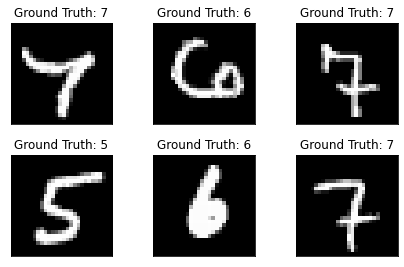

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
# train the model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), r'C:\Users\PRIME\Downloads\results\model.pth')
      torch.save(optimizer.state_dict(), r'C:\Users\PRIME\Downloads\results\optimizer.pth')

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/nfs/student/j/jpierre/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/nfs/student/j/jpierre/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153440
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096371
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944348
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839604
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.765901
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699960
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.691150
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.509462
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.395712
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.286955
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.317510
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.276078
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.391365
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.472931
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.449295
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.437896
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.262921
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.271497
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.513877
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.348677
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.367801
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.314420
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.288403
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.432334
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.193074
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.402076
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.387403
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.293651
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.331072
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.391994
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.612413
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.331080


In [15]:
print(len(train_counter), len(train_losses))
print(len(test_counter), len(test_losses))

282 282
4 4


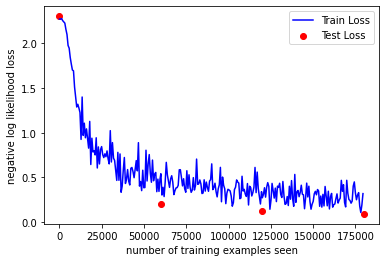

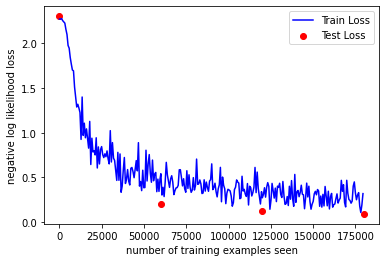

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [17]:
with torch.no_grad():
  output = network(example_data)

/nfs/student/j/jpierre/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


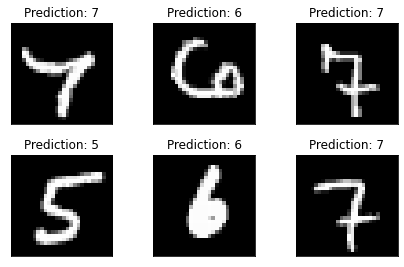

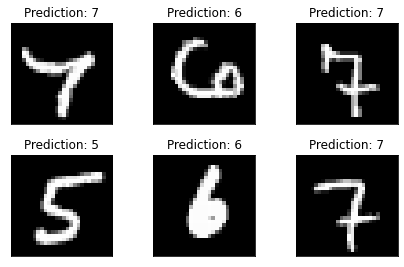

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [20]:
network_state_dict = torch.load(r'C:\Users\PRIME\Downloads\results\model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load(r'C:\Users\PRIME\Downloads\results\optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [21]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/nfs/student/j/jpierre/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.319854
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.287552
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.178282
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.152783
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.344482
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.578113
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.273788
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.292251
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.345743
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.232740
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.518780
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.199659
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.257857
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.170456
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.314861
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.179851
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.167321
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.244233
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.341828
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.322008
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.207302
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.119188
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.262010
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.428625
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.366921
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.148220
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.258880
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.386074
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.092078
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.167740
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.248737
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.317785
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.385404
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.223476
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.220844
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.119143
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.250550
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.498758
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.133264
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.318353


Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.195194
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.230698
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.255942
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.251946
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.227523
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.304973
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.284852
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.225036
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.218715
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.526025
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.090503
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.134700
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.101984
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.245102
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.140026
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.086841
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.302767
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.205851
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.208074
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.311355


In [22]:
print(len(train_counter), len(train_losses))
print(len(test_counter), len(test_losses))

752 752
9 9


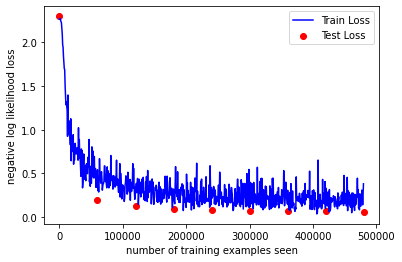

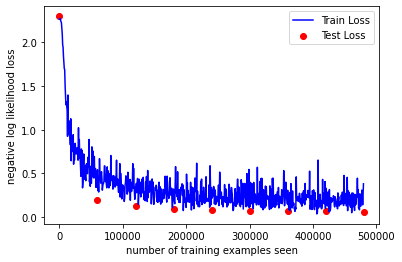

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig